# Random sample imputation 

**Definition**
  - Replacing each missing data point with a randomly sampled value from available observations. 
  - Can be used for both numerical and categorical variables 
  - **Use train data for sampling for test dataset** 
   ![](images/random_sample_imputation.png)

**Assumptions**
  * Data is missing at random 
  * The population of missing values is the same as that of the original variable

**Advantages**
  * Easy and fast implementation 
  * Preserves the variance and distribution of the variable (important for linear models)

**Limitations**
  * Randomness. Hard to replicate as different random samples will fill missing data. Same observation, different predictions. e.g. random loan approval (Overcome by setting the seed)
  * Covariance may change if a lot of missing values 
  * Memory heavy for deployment. Need to save the original data set for future random sampling in production

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('../data/house_price/train.csv')

In [3]:
df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [10]:
# numerical columns
numerical = df.select_dtypes(np.number).columns

# numerical variables that have nulls 
null_num_cols = numerical[df[numerical].isnull().mean() > 0]
null_num_cols

Index(['LotFrontage', 'MasVnrArea', 'GarageYrBlt'], dtype='object')

# Split data 

In [11]:
cols = null_num_cols

X_train, X_test, y_train, y_test = train_test_split(df[cols], df['SalePrice'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((1022, 3), (438, 3))

In [13]:
X_train.isnull().mean()

LotFrontage    0.184932
MasVnrArea     0.004892
GarageYrBlt    0.052838
dtype: float64

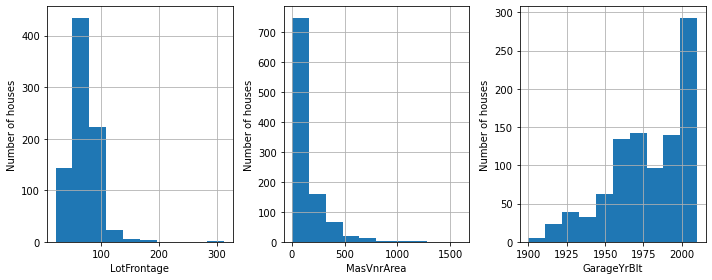

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i, col in enumerate(X_train.columns):
    ax = plt.subplot(1, 3, i+1)
    X_train[col].hist()
    ax.set_xlabel(col)
    ax.set_ylabel('Number of houses')

plt.tight_layout()
plt.show()

# Random sampling

In [27]:
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

In [61]:
for col in X_train.columns:
    # get null observations 
    X_train_null = X_train[X_train[col].isnull()]
    X_test_null = X_test[X_test[col].isnull()]
    
    # get random samples from X_train with the number of null observations 
    X_train_sample = X_train[col].dropna().sample(len(X_train_null.index), random_state=0).to_list()
    X_test_sample = X_train[col].dropna().sample(len(X_test_null.index), random_state=0).to_list()
    
    # replace null values with random samples
    X_train_imputed.loc[X_train_null.index, col] = X_train_sample
    X_test_imputed.loc[X_test_null.index, col] = X_test_sample

In [62]:
X_train_imputed.isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

# Check data stats after imputation

## variance

In [63]:
X_train.var()

LotFrontage      532.587202
MasVnrArea     32983.538710
GarageYrBlt      624.305948
dtype: float64

In [64]:
X_train_imputed.var()

LotFrontage      581.883936
MasVnrArea     32874.010156
GarageYrBlt      621.417236
dtype: float64

## covariance

In [65]:
X_train.cov()

,LotFrontage,MasVnrArea,GarageYrBlt
LotFrontage,532.587202,680.560330,30.611717
MasVnrArea,680.560330,32983.538710,1203.583792
GarageYrBlt,30.611717,1203.583792,624.305948


In [66]:
X_train_imputed.cov()

,LotFrontage,MasVnrArea,GarageYrBlt
LotFrontage,581.883936,562.797010,33.665205
MasVnrArea,562.797010,32874.010156,1114.653218
GarageYrBlt,33.665205,1114.653218,621.417236


## outliers

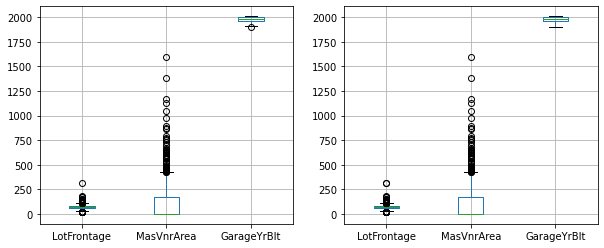

In [70]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# before imputation
ax = plt.subplot(1, 2, 1)
X_train.boxplot()

# after imputation
ax = plt.subplot(1, 2, 2)
X_train_imputed.boxplot()

plt.show()